# Group 2 Project idea: Understanding pardon and clemency rates among different presidents and eras.

### project motivation:
- rates of the incarceration rates per year, and the top pardons that were given out for that year

- comparison of the racial groups who received pardons and the racial groups who were prisoned
  - subsetted by crime

- rates of pardons per president
  - racial, gender, age bias
  - crime bias

- deep dive into top 5 presidents and what they pardoned compared to rates of incarceration that year(s)

- see how many non-citizens were granted pardons

- how do pardons vary across admins

- what time frame do the most pardons occur per president, end of term?
  - is there a “midnight” pardon spike at end of presidential term

- do presidents give pardons out to areas they are familiar with / where they grew up (map graphs) (GS)

In [ ]:
#(GS-code orginator)
# (EK - code reviser)
# (KS - code reviewer)
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from IPython.display import display

Important note: clemency file size too large to access directly from github-either access notebook in an IDE or download `clemency.csv` and add in files in colab each time

In [2]:
df = pd.read_csv('./clemency.csv', encoding='latin-1')
# df.tail()
# df.columns

## Data cleaning and preprocessing

In [3]:
df.count() #(GS - code reviewer)

CASEID          32026
FILEID          32026
PRES            32026
PRESIDENT       32026
TERMYR          32026
                ...  
TOTALWAIT         257
PRISON          18740
V22             32026
V23             32026
TOWHITEHOUSE    32026
Length: 77, dtype: int64

In [4]:
#(GS-code orginator)
df_clean = df.copy()

date_cols = ['DATECONVICTION', 'DATEACTION', 'DATE1', 'FILED']
for col in date_cols:
    df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')

num_cols = ['TERMYR', 'AGE', 'TOTALWAIT']
for col in num_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

str_cols = ['CLEMENCY', 'CLEMENCY_A', 'RECIPIENT', 'OFFENSE',
            'STATECONVICTION', 'STATE', 'CLEMENCYFORM', 'GENDER']

for col in str_cols:
    df_clean[col] = (
        df_clean[col]
        .astype('string')
        .str.strip()
    )

df_clean['GENDER'] = (
    df_clean['GENDER']
    .str.upper()
    .replace({
        'MALE': 'M',
        'FEMALE': 'F',
        'M.': 'M',
        'F.': 'F',
        '0' : 'M',
        '1' : 'F'
    })
)

missing = df_clean.isna().mean().sort_values(ascending=False)
print("Fraction of missing values per column:")
print(missing)


key_cols = ['PRES', 'CLEMENCY', 'DATEACTION'] #TERMYR removed #(EK - code reviser) #(GS - code reviewer)
df_model = df_clean.dropna(subset=key_cols).reset_index(drop=True) #drops any row with any missing values in our 4 columns

df_rows_lost = df.shape[0]-df_model.shape[0]
print(f'{df_rows_lost} rows were valiantly sacrificed in the cleaning process ({df_rows_lost/df.shape[0]*100}% of the total)')

/var/folders/2g/jqjm37dn3q74zcdhwhq_1k3w0000gn/T/ipykernel_29941/141263959.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')
/var/folders/2g/jqjm37dn3q74zcdhwhq_1k3w0000gn/T/ipykernel_29941/141263959.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')


Fraction of missing values per column:
FORM            0.999282
DATE1           0.999126
SUSP            0.998782
LAWYER          0.998220
FINE_A          0.998064
                  ...   
V28             0.000000
FILEID          0.000000
VIOLENT         0.000000
AMOUNT          0.000000
TOWHITEHOUSE    0.000000
Length: 77, dtype: float64
945 rows were valiantly sacrificed in the cleaning process (2.9507275338787236% of the total)


/var/folders/2g/jqjm37dn3q74zcdhwhq_1k3w0000gn/T/ipykernel_29941/141263959.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')
/var/folders/2g/jqjm37dn3q74zcdhwhq_1k3w0000gn/T/ipykernel_29941/141263959.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean[col] = pd.to_datetime(df_clean[col],  errors='coerce')


FORM                 0.999282
DATE1                0.999126
SUSP                 0.998782
LAWYER               0.998220
FINE_A               0.998064
PARD                 0.997689
SENTENCE             0.997596
FILED                0.996878
SERVEDSENTENCE       0.996440
MIL                  0.996253
CRIMECAT             0.995629
DIFF_A               0.995316
W1C2D3V4TR5M         0.995129
CLEMENCYFORM         0.994099
SUPERVISEDRELEASE    0.993724
FORMOFCLEMENCY       0.993724
AGE                  0.992225
BUREACRACY           0.992006
DAYSTODECIDE         0.992006
TOTALWAIT            0.991975
PROB_A               0.988759
ORDER                0.987135
GENDER               0.985637
PROBATION            0.984731
SENT_A               0.981921
PROB                 0.981109
STATEJAIL            0.957066
SUP                  0.940985
DIFF                 0.903859
MONTH_A              0.873915
SSID                 0.792700
TERMYR               0.756292
AGREP                0.717511
PG_A      

(array([36.,  0.,  2.,  0.,  2.,  0.,  3.,  4.,  1., 29.]),
 array([0.        , 0.09992818, 0.19985637, 0.29978455, 0.39971273,
        0.49964092, 0.5995691 , 0.69949728, 0.79942547, 0.89935365,
        0.99928183]),
 <BarContainer object of 10 artists>)

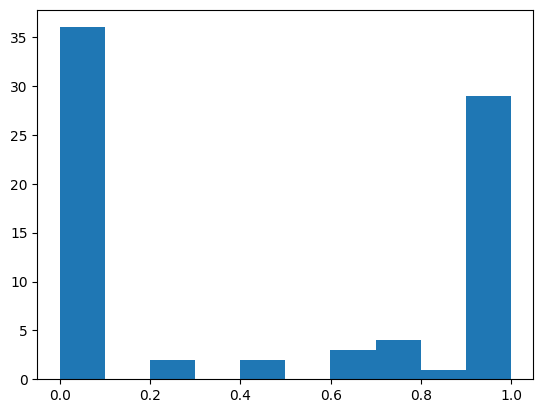

In [6]:
#Function that lets me display things with a custom # of rows #(EK - code originator)
# (KA - code reviewer)
# (GS - code reviser)
def Display_Max_Rows(info, rows = None):
  pd.set_option('display.max_rows', rows)
  print(info) #I wondered for a moment if decorators would let me do this with functions instead of just data (e.g. Display_Max_Rows(print(missing))) but I have to shelve that for now.
  pd.set_option('display.max_rows', 10)

#Display every column's missing %
Display_Max_Rows(missing)

#a histogram just for fun
plt.hist(missing)

From the above results, columns like `DATEACTION` and `DATECONVICTION`, and are usable while columns like `DATE1`, `FILED`, `CLEMENCYFORM`, `AGE`,`TOTALWAIT`, and `GENDER` are unsable with around 99%+ data missing from these columns.
  - some might only exist for modern years-to find out

In [7]:
#(GS-code orginator)
df_model[['PRES', 'TERMYR', 'CLEMENCY']].value_counts().head(20)

#(EK - code originator)
Display_Max_Rows(df_model.groupby('PRES')['CASEID'].count().sort_values(ascending=False)) #EK

PRES
FDR           3609
Truman        2044
Obama         1928
              1662
Wils(2)       1600
Grant         1336
Hoov          1223
LBJ           1187
Cool2         1174
Eisen         1155
Nix            925
Hayes          903
McKin          881
Wils(1)        871
Hard           806
B.Harr         665
Johns          654
Cleve (2)      605
Kenn           572
Cart           567
TRoos (1)      517
Cleve          479
Clin           460
T.Roos         460
Monr           425
Ford           409
Reag           407
Jack           388
Cool           388
Linc           343
Arthur         282
Bush           278
Polk           268
Tyler          209
Madis          201
JQAd           183
Fill           171
VanB           168
Buch           149
Pierce         141
  Jeff          73
Taft            69
Jeff            43
Taylor          38
- warrant       28
Adams           21
Wash            19
-  warrant      11
CANC             9
fDR              8
warrant fo       6
- extradit       6
arrest 

            CASEID  FILEID  PRES  PRESIDENT  TERMYR   PG  PG_A  PAGE  SSVOL  \
YEARACTION                                                                    
1791             1       1     1          1       0    0     0     0      0   
1793             2       2     2          2       0    0     0     0      0   
1794             7       7     7          7       0    5     0     0      5   
1795             4       4     4          4       0    4     0     0      4   
1796             5       5     5          5       0    4     0     0      4   
1797            12      12    12         12       0    3     0     0      3   
1798             3       3     3          3       3    3     0     0      3   
1799             7       7     7          7       5    5     0     0      5   
1800            13      13    13         13       9    9     0     0      9   
1801            24      24    24         24      13   13     0     0     13   
1802            10      10    10         10       8 

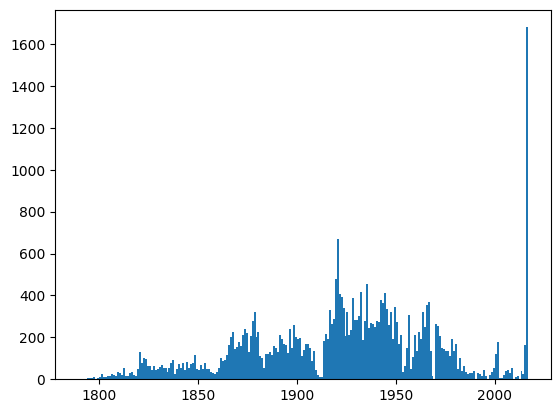

In [ ]:
#(EK - code originator)
# (GS - code reviwer/reviser)

#another angle, charting each row by its year
#about 3% of DATEACTION is missing so please keep this in mind
df_model['YEARACTION'] = df_model['DATEACTION'].dt.year
plt.hist(df_model['YEARACTION'], bins = range(1789,2018))

Display_Max_Rows(df_model.groupby('YEARACTION').count())

Originally we had TERMYR included as a key for dropping missingness, but it caused huge gaps in the dataset, as can be seen here:

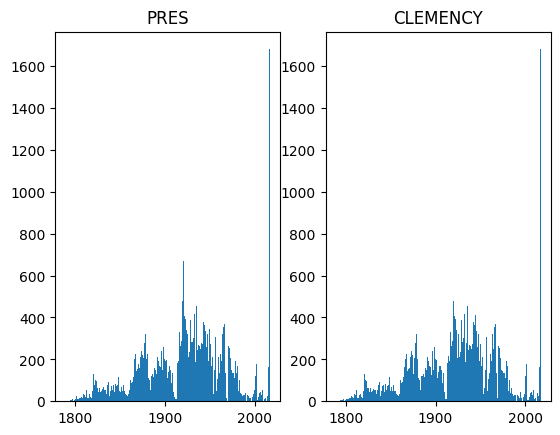

In [ ]:
#Where is the missingness?
#(EK - code originator)
# (GS - code reviser/reviewer)
key_cols_test = key_cols.copy()
key_cols_test.remove('DATEACTION')

fig, ax = plt.subplots(nrows = 1,ncols = len(key_cols_test))
df_clean_test = {}
for k in range(len(key_cols_test)):
  df_clean_test[k] = df_clean.dropna(subset=key_cols_test[k]).reset_index(drop=True)
  ax[k].hist(df_clean_test[k]['DATEACTION'].dt.year, bins = range(1789,2018))
  ax[k].set_title(key_cols_test[k])


And thus, TERMYR was removed.

## Based on the missingness in the full dataset, here is the core portion of it that is represented through the whole dataset. Here columns are only missing 0-5% of their data.
- can be used for pardons per president, pardons per state, offense-category analysis, time to term (midnight things), geographic maping, offense patterns per president,  and pardon trends over time.

In [ ]:
#(GS-code orginator)
# (EK - code reviser)
core_cols = [
    'CASEID', 'FILEID', 'PRES', 'CLEMENCY', 'CLEMENCY_A',
    'DATEACTION', 'RECIPIENT', 'OFFENSE',
    'STATECONVICTION', 'STATE'
]

df_core = df_clean[core_cols].dropna(subset=['DATEACTION'])
print(df_core.shape)
# df_core.head()
# print(df_core['PRES'].unique())

# top three pardon givers
pardon_counts = df_core['PRES'].value_counts()
print(pardon_counts.head(3))

(31081, 10)
PRES
FDR           3609
Truman        2044
Obama         1928
Name: count, dtype: int64


## Geographic exploration

 create a map of where each unique  `PRES` has approved a pardon across the united states (for each unique PRES field map the STATECONVICTION field)

### To discover where the presidents were born to inform future exploration

In [ ]:
# (GS - code originator)
# (KA - code reviewer/reviser)
df_pres_from = pd.read_csv('./Presidential-birth-place.csv', encoding='latin-1')

# Birth states for highlighted presidents:
df_pres_from.loc[df_pres_from["President"] == "Barack Obama", "Birth State"].iloc[0]

'HI'

### Visualization of counts for where each president is born. Done to see exactly where the US presidents are from

In [12]:
# (GS - code originator)
pres_by_state = df_pres_from.groupby('Birth State').size().reset_index(name='Number of Presidents')
pres_by_state.columns = ['State', 'Number of Presidents']

# Create a map of the US showing president birth states
fig = px.choropleth(
    pres_by_state,
    locations='State',
    locationmode='USA-states',
    color='Number of Presidents',
    hover_name='State',
    hover_data={'Number of Presidents': True},
    color_continuous_scale='Blues',
    scope='usa',
    title='US Presidents by Birth State',
    labels={'Number of Presidents': 'Number of Presidents'}
)

fig.update_layout(
    title={
        'text': 'US Presidents by Birth State',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}})

fig.show()


### Creating new cleaned President column for easier understanding

In [ ]:
# (GS - code originator)
# (KA - code reviewer/reviser)
df_core['PRESIDENT'] = df_core['PRES'].str.replace(r'\s*\([^\)]*\)', '', regex=True).str.strip()
# df_core.head()
df_core.shape

# Standardize known inconsistencies among the state columns, how states were represented was changed as this data was acquired
# (og in STATE column and then moved to STATECONVICTION column)
valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID',
    'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO',
    'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA',
    'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY',
    'AS', 'GU', 'MP', 'VI', 'UM'
]

state_fix_map = {
    'Puerto': 'PR',
    'Guam': 'GU',
    'CN': 'CT',
    'HA': 'HI',
    'KA': 'KS'
}

df_core['STATECONVICTION'] = df_core['STATECONVICTION'].replace(state_fix_map)
df_core['STATE'] = df_core['STATE'].replace(state_fix_map)

# Replace non-valid states with NaN
df_core['STATECONVICTION'] = df_core['STATECONVICTION'].apply(lambda x: x if x in valid_states else None)
df_core['STATE'] = df_core['STATE'].apply(lambda x: x if x in valid_states else None)

df_core.head()
df_core.shape


(31081, 11)

### Discovery of data input for where each state the convicted were given the pardon (either where they were from or where the crime was committed. In this case, this distinction is not necessary)

In [ ]:
# (GS - code originator)
# (KA - code reviewer/reviser)
df_pardon_counts = df_core.groupby(['PRESIDENT', 'STATECONVICTION']).nunique().reset_index()
df_pardon_counts.rename(columns={'CASEID': 'PARDON_COUNT'}, inplace=True)
df_pardon_counts['PRESIDENT'] = df_pardon_counts['PRESIDENT'].str.replace(r',\s*\d(st|nd|rd|th) Term\)', '', regex=True).str.strip()
# After cleaning, all are Obama based on completeness of data-> Obama's specific dataframe based on data input

df_pardon_counts.head()
df_pardon_counts.shape

# previous way of inputting data for remaining top pardon givers:
df_pardon_counts_other = df_core.groupby(['PRESIDENT', 'STATE']).nunique().reset_index()
df_pardon_counts_other.rename(columns={'CASEID': 'PARDON_COUNT'}, inplace=True)
df_pardon_counts_other['PRESIDENT'] = df_pardon_counts_other['PRESIDENT'].str.replace(r',\s*\d(st|nd|rd|th) Term\)', '', regex=True).str.strip()

df_pardon_counts_other.shape
# df_pardon_counts_other['PRESIDENT'].unique()

(1603, 11)

### Map of Obama's pardons and where he is from:

In [15]:
# (GS - code originator)
# Only Obama due to cleaning reasons from STATECONVICTION column -> updated how they inputted these
df_pardon_counts_Obama = df_pardon_counts[df_pardon_counts['PRESIDENT'] == 'Obama']

fig = px.choropleth(
    df_pardon_counts_Obama,
    locations='STATECONVICTION',
    locationmode='USA-states',
    color='PARDON_COUNT',
    hover_name='STATECONVICTION',
    hover_data={'PARDON_COUNT': True},
    color_continuous_scale='Blues',
    scope='usa',
    title='US President Obama by Pardon Frequency',
    labels={'PARDON_COUNT': 'Number of Presidential Pardons'}
)
#FOR HAWAII
birth_lat = 21.3069
birth_lon = -157.8583

fig.add_scattergeo(
    lon=[birth_lon],
    lat=[birth_lat],
    mode='markers+text',
    marker=dict(size=10, color='red'),
    text=["Birthplace (HI)"],
    textposition="top center",
    name="Obama Birthplace"
)

fig.update_layout(
    title={
        'text': 'US President Obama by Pardon Frequency',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    }
)

fig.show()

### Map of George W. Bush's pardons and where he is from:

In [16]:
# (GS - code originator)
df_pardon_counts_Bush = df_pardon_counts_other[df_pardon_counts_other['PRESIDENT'] == 'Bush']

fig = px.choropleth(
    df_pardon_counts_Bush,
    locations='STATE',
    locationmode='USA-states',
    color='PARDON_COUNT',
    hover_name='STATE',
    hover_data={'PARDON_COUNT': True},
    color_continuous_scale='Blues',
    scope='usa',
    title='US President George W. Bush by Pardon Frequency',
    labels={'PARDON_COUNT': 'Number of Presidential Pardons'}
)

# FOR CT (New Haven area)
birth_lat = 41.3083
birth_lon = -72.9279

fig.add_scattergeo(
    lon=[birth_lon],
    lat=[birth_lat],
    mode='markers+text',
    marker=dict(size=10, color='red'),
    text=["Birthplace (CT)"],
    textposition="top center",
    name="Bush Birthplace"
)

fig.update_layout(
    title={
        'text': 'US President George W. Bush by Pardon Frequency',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    }
)

fig.show()

### Map of Harry Truman's pardons and where he is from:

In [ ]:
# (GS - code originator)
# (KA - code reviewer/reviser)
df_pardon_counts_Truman = df_pardon_counts_other[df_pardon_counts_other['PRESIDENT'] == 'Truman']

fig = px.choropleth(
    df_pardon_counts_Truman,
    locations='STATE',
    locationmode='USA-states',
    color='PARDON_COUNT',
    hover_name='STATE',
    hover_data={'PARDON_COUNT': True},
    color_continuous_scale='Blues',
    scope='usa',
    title='US President Harry S. Truman by Pardon Frequency',
    labels={'PARDON_COUNT': 'Number of Presidential Pardons'}
)

# FOR Lamar, Barton County, Missouri
birth_lat = 37.4945
birth_lon = -94.2761

fig.add_scattergeo(
    lon=[birth_lon],
    lat=[birth_lat],
    mode='markers+text',
    marker=dict(size=10, color='red'),
    text=["Birthplace (MO)"],
    textposition="top center",
    name="Bush Birthplace"
)

fig.update_layout(
    title={
        'text': 'US President Harry S. Truman by Pardon Frequency',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    }
)

fig.show()

### Map of FDR's pardons and where he is from:

In [ ]:
# (GS - code originator)
# (KA - code reviewer/reviser)
df_pardon_counts_FDR = df_pardon_counts_other[df_pardon_counts_other['PRESIDENT'] == 'FDR']

fig = px.choropleth(
    df_pardon_counts_FDR,
    locations='STATE',
    locationmode='USA-states',
    color='PARDON_COUNT',
    hover_name='STATE',
    hover_data={'PARDON_COUNT': True},
    color_continuous_scale='Blues',
    scope='usa',
    title='US President FDR by Pardon Frequency',
    labels={'PARDON_COUNT': 'Number of Presidential Pardons'}
)

# FOR Hyde Park, New York
birth_lat = 41.7948
birth_lon = -73.9332

fig.add_scattergeo(
    lon=[birth_lon],
    lat=[birth_lat],
    mode='markers+text',
    marker=dict(size=10, color='red'),
    text=["Birthplace (NY)"],
    textposition="top center",
    name="Bush Birthplace"
)

fig.update_layout(
    title={
        'text': 'US President FDR by Pardon Frequency',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20}
    }
)

fig.show()

### All four maps together for better formatting in report

In [ ]:
# (GS - code originator)
# (KA - code reviewer/reviser)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# --- FILTER DATA ---
df_pardon_counts_FDR = df_pardon_counts_other[df_pardon_counts_other['PRESIDENT'] == 'FDR']
df_pardon_counts_Truman = df_pardon_counts_other[df_pardon_counts_other['PRESIDENT'] == 'Truman']
df_pardon_counts_Bush = df_pardon_counts_other[df_pardon_counts_other['PRESIDENT'] == 'Bush']
df_pardon_counts_Obama = df_pardon_counts[df_pardon_counts['PRESIDENT'] == 'Obama']

# --- CREATE 4-PANEL USA MAP (2x2) ---
fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"type": "geo"}, {"type": "geo"}],
        [{"type": "geo"}, {"type": "geo"}]
    ],
    subplot_titles=[
        "FDR Pardon Frequency",
        "Truman Pardon Frequency",
        "George W. Bush Pardon Frequency",
        "Obama Pardon Frequency"
    ]
)

#FDR
fig.add_trace(
    go.Choropleth(
        locations=df_pardon_counts_FDR['STATE'],
        locationmode='USA-states',
        z=df_pardon_counts_FDR['PARDON_COUNT'],
        text=df_pardon_counts_FDR['STATE'],
        colorbar_title="Pardons",
        colorscale="Blues"
    ),
    row=1, col=1
)

# NY
fig.add_trace(
    go.Scattergeo(
        lon=[-73.9332],
        lat=[41.7948],
        mode="markers+text",
        text=["Birthplace (NY)"],
        textposition="top center",
        marker=dict(size=10, color="red"),
        showlegend=False
    ),
    row=1, col=1
)

#Truman
fig.add_trace(
    go.Choropleth(
        locations=df_pardon_counts_Truman['STATE'],
        locationmode='USA-states',
        z=df_pardon_counts_Truman['PARDON_COUNT'],
        text=df_pardon_counts_Truman['STATE'],
        showscale=False,
        colorscale="Blues"
    ),
    row=1, col=2
)

# MO
fig.add_trace(
    go.Scattergeo(
        lon=[-94.2761],
        lat=[37.4945],
        mode="markers+text",
        text=["Birthplace (MO)"],
        textposition="top center",
        marker=dict(size=10, color="red"),
        showlegend=False
    ),
    row=1, col=2
)

#Bush
fig.add_trace(
    go.Choropleth(
        locations=df_pardon_counts_Bush['STATE'],
        locationmode='USA-states',
        z=df_pardon_counts_Bush['PARDON_COUNT'],
        text=df_pardon_counts_Bush['STATE'],
        showscale=False,
        colorscale="Blues"
    ),
    row=2, col=1
)

# CT
fig.add_trace(
    go.Scattergeo(
        lon=[-72.9279],
        lat=[41.3083],
        mode="markers+text",
        text=["Birthplace (CT)"],
        textposition="top center",
        marker=dict(size=10, color="red"),
        showlegend=False
    ),
    row=2, col=1
)

# Obama
fig.add_trace(
    go.Choropleth(
        locations=df_pardon_counts_Obama['STATECONVICTION'],
        locationmode='USA-states',
        z=df_pardon_counts_Obama['PARDON_COUNT'],
        text=df_pardon_counts_Obama['STATECONVICTION'],
        showscale=False,
        colorscale="Blues"
    ),
    row=2, col=2
)

# Hawaii
fig.add_trace(
    go.Scattergeo(
        lon=[-157.8583],
        lat=[21.3069],
        mode="markers+text",
        text=["Birthplace (HI)"],
        textposition="top center",
        marker=dict(size=10, color="red"),
        showlegend=False
    ),
    row=2, col=2
)

fig.update_layout(
    title_text="Presidential Pardon Frequency & Birthplaces (FDR, Truman, Bush, Obama)",
    title_x=0.5,
    height=800,
    geo=dict(scope='usa'),
    geo2=dict(scope='usa'),
    geo3=dict(scope='usa'),
    geo4=dict(scope='usa')
)

fig.show()


## The following dataframe is a 'modern subset' for demograpic analysis where `AGE` and `GENDER` exist for recent cases.

- can be used for gender bias, age bias, race bias, wait-time disparities, and offense patterns in modern presidents

- **since so many entries are missing for age and gender, this is not an avenue we will be exploring**

In [20]:
#(GS-code orginator)
df_demo = df_clean[df_clean['AGE'].notna() & df_clean['GENDER'].notna()]
print(df_demo.shape)
# df_demo.head()

(133, 77)


## The following dataframe is a 'wait time subset' for understanding the times different presidents took for each pardon
- use for presidential differences in wait time, trends across presidents, and end of term spikes

- In the context of the criminal justice system and pardons, "date of action" typically refers to the date the crime occurred (offense date) or when an arrest was made, while "date of conviction" is the date a court found an individual guilty and imposed a sentence. This distinction is critical for determining eligibility and waiting periods for a pardon

In [21]:
#(GS-code orginator)
df_clean['WAIT_DAYS'] = (
    df_clean['DATEACTION'] - df_clean['DATECONVICTION']
).dt.days

df_wait = df_clean[df_clean['WAIT_DAYS'].notna()]
print(df_wait.shape)
# df_wait.head()
# df_wait.columns

(25173, 78)


## Calculate Average Wait Time per President

Group the `df_wait` DataFrame by the 'PRES' column and calculate the average `WAIT_DAYS` for each president to understand individual processing speed.


Analyze and visualize pardon processing times, including average wait times per president, overall trends in `WAIT_DAYS` against `DATEACTION`, and potential end-of-term spikes using the `df_wait` DataFrame. Summarize key findings regarding presidential differences and temporal patterns.

In [22]:
#(GS-code orginator)
avg_wait_time_per_president = df_wait.groupby('PRES')['WAIT_DAYS'].mean().sort_values(ascending=False)
print("Average Wait Time (in Days) per President:")
# print(avg_wait_time_per_president)
display(avg_wait_time_per_president.head())

Average Wait Time (in Days) per President:


PRES
Wils(1)       7898.818182
Bush          7777.021818
Reag          6252.144963
Taft          5927.357143
Clin          5687.164114
Name: WAIT_DAYS, dtype: float64

## Plot Wait Time Trends Over Time

Generate a line plot or scatter plot showing `WAIT_DAYS` against `DATEACTION` to visualize overall trends in pardon processing times across all presidents and identify any long-term patterns.


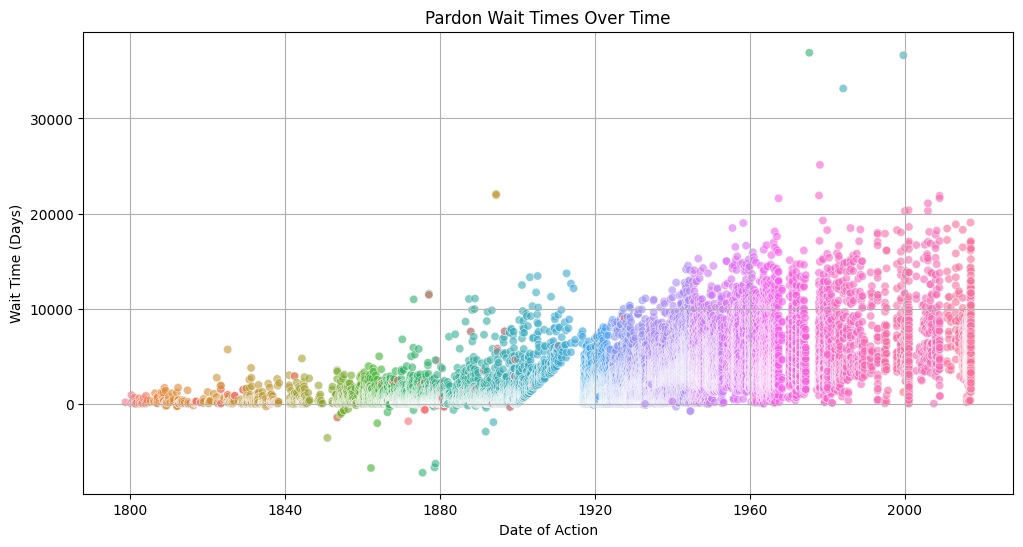

In [ ]:
#(GS-code orginator)
# (KA - code reviewer/reviser)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='DATEACTION', y='WAIT_DAYS', data=df_wait, alpha=0.6, hue='PRES', legend=False)
plt.xlabel('Date of Action')
plt.ylabel('Wait Time (Days)')
plt.title('Pardon Wait Times Over Time')
plt.grid(True)
plt.show()

smoothed version with trend line to see changes in easier way

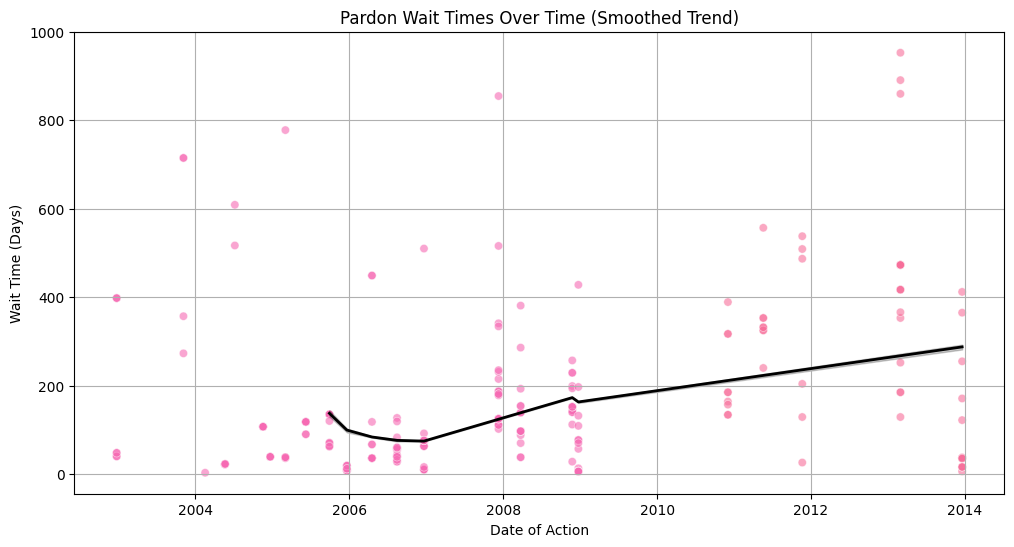

In [ ]:
#(GS-code orginator)
# (KA - code reviewer/reviser)
df_wait = df_wait.sort_values('DATEACTION')
df_wait['ROLL_MEAN'] = df_wait['DAYSTODECIDE'].rolling(window=50).mean()

plt.figure(figsize=(12, 6))

sns.scatterplot(x='DATEACTION', y='DAYSTODECIDE',data=df_wait, alpha=0.6, hue='PRES', legend=False)
sns.lineplot(x='DATEACTION', y='ROLL_MEAN',data=df_wait, color='black', linewidth=2)

plt.xlabel('Date of Action')
plt.ylabel('Wait Time (Days)')
plt.title('Pardon Wait Times Over Time (Smoothed Trend)')
plt.grid(True)
plt.show()

## Analyze End-of-Term Spikes in Wait Times

Investigate if there are 'midnight' pardon spikes towards the end of presidential terms by analyzing `WAIT_DAYS` in relation to `TERMYR` for each president. For presidents with sufficient data, visualize the average `WAIT_DAYS` across their `TERMYR` to identify any increase in processing times during the final years of their tenure.


In [ ]:
# (GS - code originator)
# (KA - code reviewer/reviser)
avg_wait_time_by_term = df_wait.groupby(['PRES', 'TERMYR'])['WAIT_DAYS'].mean().reset_index()

print("Average Wait Time (in Days) by President and Term Year:")
display(avg_wait_time_by_term.head())

presidents_with_multiple_terms = avg_wait_time_by_term.groupby('PRES').filter(lambda x: x['TERMYR'].nunique() > 1)

# print("\nPresidents with data for multiple term years:")
# display(presidents_with_multiple_terms[['PRES']].drop_duplicates())


Average Wait Time (in Days) by President and Term Year:


,PRES,TERMYR,WAIT_DAYS
0,Jeff,2.0,31.000000
1,Adams,2.0,154.000000
2,Adams,4.0,311.750000
3,Buch,1.0,548.444444
4,Buch,2.0,697.285714


## Visualize Presidential Differences in Wait Time

Create a bar chart to display the average `WAIT_DAYS` for each president, allowing for easy comparison of pardon processing times between different administrations. Ensure the plot has appropriate labels and a legend.


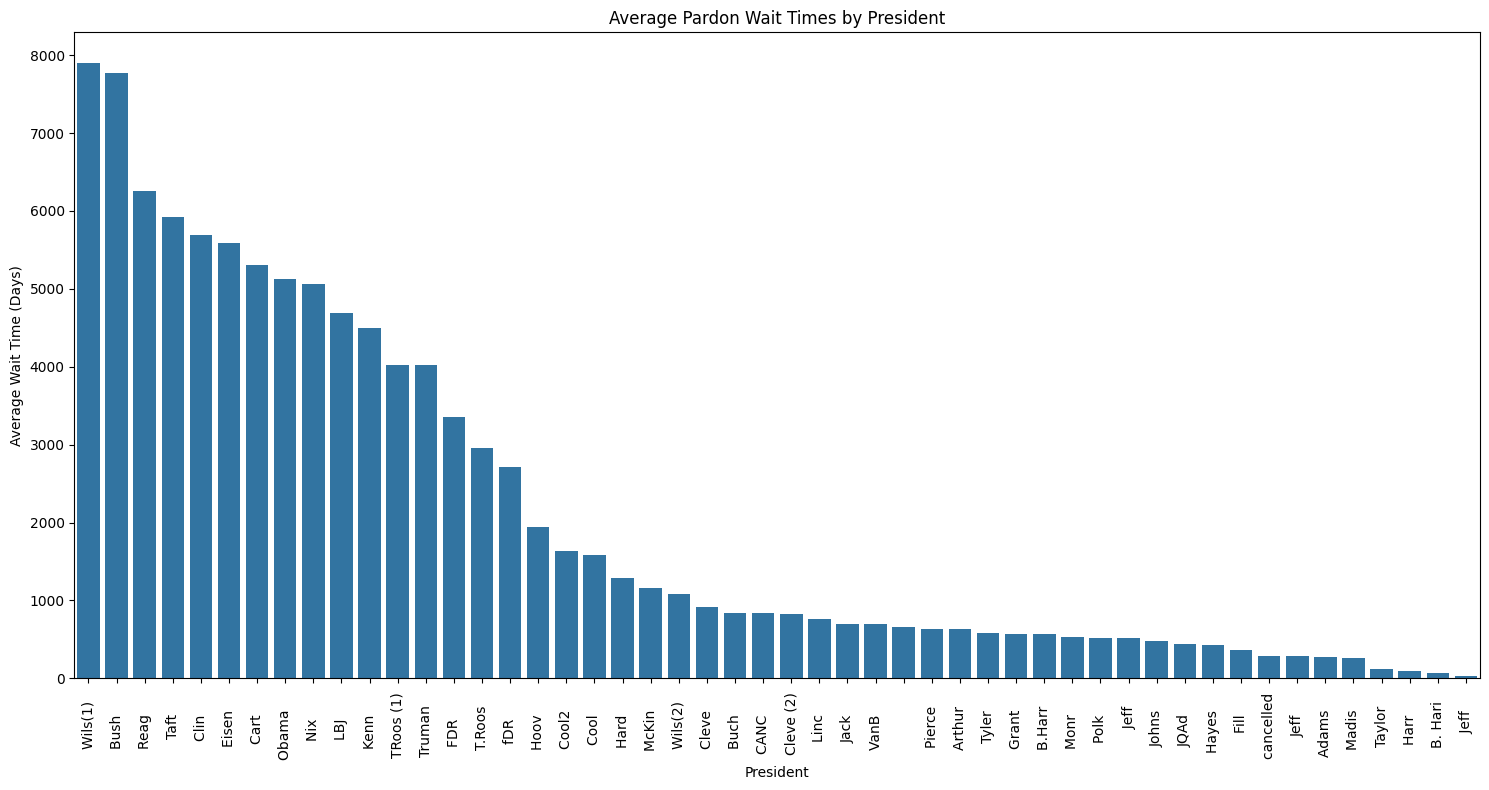

In [ ]:
#(GS-code orginator)
# (KA - code reviewer/reviser)
plt.figure(figsize=(15, 8))
sns.barplot(x=avg_wait_time_per_president.index, y=avg_wait_time_per_president.values)
plt.xlabel('President')
plt.ylabel('Average Wait Time (Days)')
plt.title('Average Pardon Wait Times by President')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Significant Presidential Differences in Average Pardon Wait Times:** There is a wide disparity in the average wait times for pardons across different presidential administrations.
    *   Presidents like 'Wils(1)' (7898.8 days) and 'Bush' (7777.0 days) had exceptionally long average wait times.
    *   Conversely, 'B. Hari' (65.0 days), 'Harr' (89.0 days), and ' Jeff' (31.0 days) showed significantly shorter average processing times.
*   **Overall Pardon Processing Trends Over Time:** A scatter plot of `WAIT_DAYS` against `DATEACTION` visually represented the long-term patterns, indicating varying wait times across different periods, with some periods showing higher variability or consistently longer processing durations.
*   **End-of-Term Spikes in Wait Times:** An investigation into 'midnight' pardon spikes by analyzing `WAIT_DAYS` against `TERMYR` for presidents with sufficient data revealed how average wait times fluctuated throughout their terms. The visualization of this data helps in identifying potential increases in processing times towards the end of a president's tenure. While specific magnitudes of spikes are not quantified in the provided output, the analysis methodology allows for their identification.



Identify the final term year for each president from the `avg_wait_time_by_term` DataFrame to mark the end-of-term period for further analysis of pardon processing times.

In [ ]:
#(GS-code orginator)
# (KA - code reviewer/reviser)
final_term_years = avg_wait_time_by_term.groupby('PRES')['TERMYR'].max()
print("Final Term Year for Each President:")
print(final_term_years.head())

Final Term Year for Each President:
PRES
 Jeff         2.0
Adams         4.0
Buch          4.0
Bush          4.0
Cart          4.0
Name: TERMYR, dtype: float64


## Segregate Wait Times for Analysis

Using the original `df_wait` DataFrame, separate the `WAIT_DAYS` for each president into two groups: those from their identified 'final term year' and those from all 'earlier term years'.


In [ ]:
#(GS-code orginator)
# (KA - code reviewer/reviser)
final_term_years_df = final_term_years.reset_index()
final_term_years_df.columns = ['PRES', 'final_term_year']

df_merged = pd.merge(df_wait, final_term_years_df, on='PRES', how='left')
df_merged['is_final_term'] = df_merged['TERMYR'] == df_merged['final_term_year']

df_final_term_pardons = df_merged[df_merged['is_final_term']].copy()
df_earlier_term_pardons = df_merged[~df_merged['is_final_term']].copy()

print("Shape of DataFrame for final term pardons:", df_final_term_pardons.shape)
print("Shape of DataFrame for earlier term pardons:", df_earlier_term_pardons.shape)

Shape of DataFrame for final term pardons: (2004, 81)
Shape of DataFrame for earlier term pardons: (23169, 81)


The shapes of the dataframe show the differences in amount of pardons give in earlier terms vs final terms

## Calculate Averages for Comparison

Calculate the average `WAIT_DAYS` for both the 'final term year' group and the 'earlier term years' group for each president, storing these averages for comparison.


In [ ]:
#(GS-code orginator)
# (KA - code reviewer/reviser)
avg_final_term_wait_time = df_final_term_pardons.groupby('PRES')['WAIT_DAYS'].mean().reset_index()
print("Average Wait Time (in Days) for Final Term Year Pardons per President:")
display(avg_final_term_wait_time.head())

avg_earlier_term_wait_time = df_earlier_term_pardons.groupby('PRES')['WAIT_DAYS'].mean().reset_index()
print("\nAverage Wait Time (in Days) for Earlier Term Year Pardons per President:")
display(avg_earlier_term_wait_time.head())

print("\nComparison of Average Wait Time (Final vs. Earlier Term):")
comparison_df = pd.DataFrame({
    'Final Term Avg Wait': avg_final_term_wait_time.set_index('PRES')['WAIT_DAYS'],
    'Earlier Term Avg Wait': avg_earlier_term_wait_time.set_index('PRES')['WAIT_DAYS']
}).dropna().reset_index()

display(comparison_df.head())

Average Wait Time (in Days) for Final Term Year Pardons per President:


,PRES,WAIT_DAYS
0,Jeff,31.000000
1,Adams,311.750000
2,Buch,996.700000
3,Bush,7097.709091
4,Cart,4799.247059



Average Wait Time (in Days) for Earlier Term Year Pardons per President:


,PRES,WAIT_DAYS
0,,659.721779
1,Jeff,514.444444
2,Adams,154.000000
3,Arthur,633.088496
4,B. Hari,65.000000



Comparison of Average Wait Time (Final vs. Earlier Term):


,PRES,Final Term Avg Wait,Earlier Term Avg Wait
0,Adams,311.750000,154.000000
1,Buch,996.700000,689.028986
2,Bush,7097.709091,7946.850000
3,Cart,4799.247059,5526.462121
4,Hoov,1957.161663,1928.845269


<Figure size 1500x800 with 0 Axes>

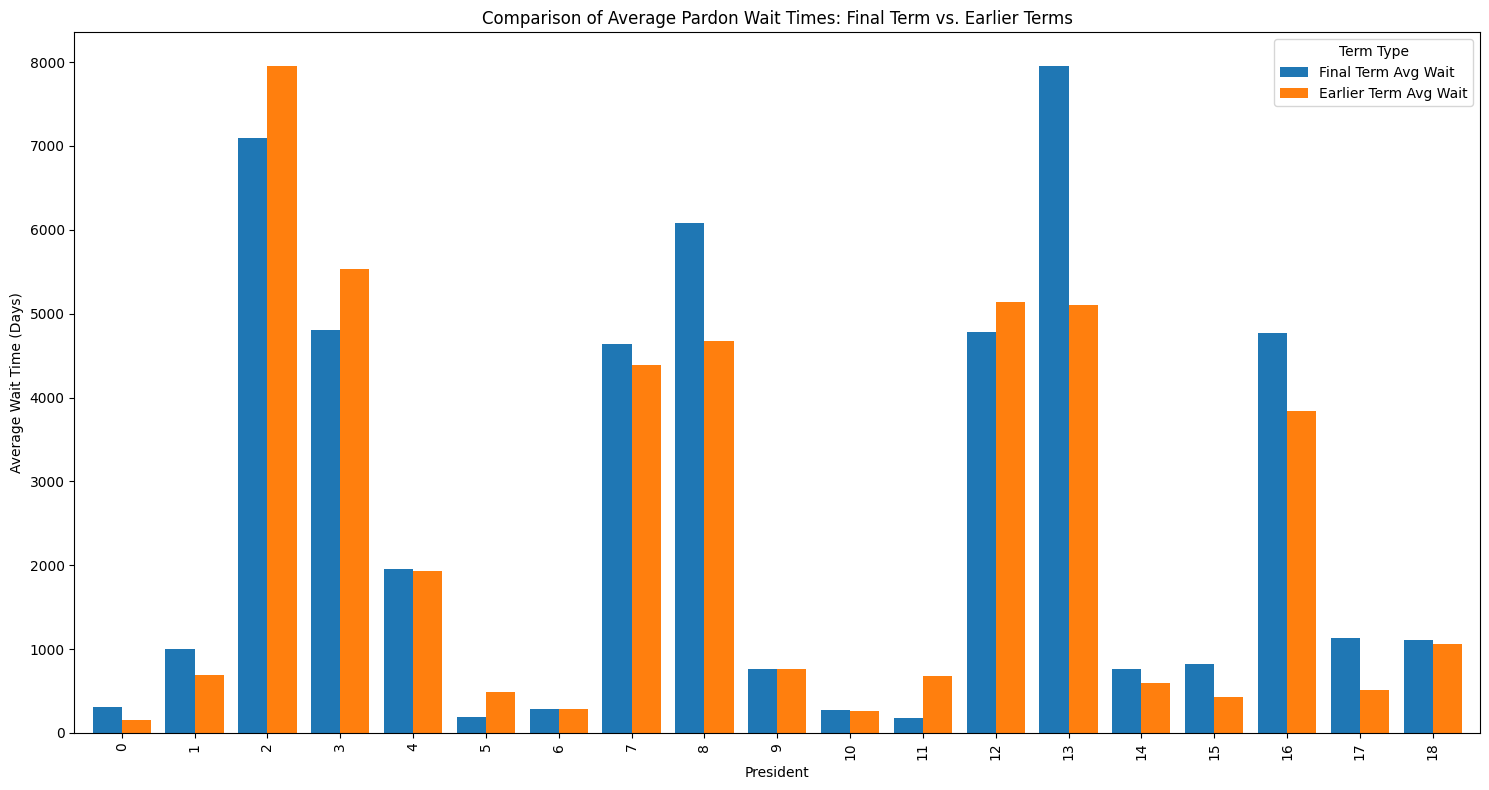

In [30]:
#(GS-code orginator)
plt.figure(figsize=(15, 8))
comparison_df.plot(kind='bar', figsize=(15, 8), width=0.8)
plt.xlabel('President')
plt.ylabel('Average Wait Time (Days)')
plt.title('Comparison of Average Pardon Wait Times: Final Term vs. Earlier Terms')
plt.xticks(rotation=90)
plt.legend(title='Term Type')
plt.tight_layout()
plt.show()

# Visualizing trend in pardon spikes over time

## We wanted to see the changes in number of pardons over the course of the exisitence of the US 

/var/folders/2g/jqjm37dn3q74zcdhwhq_1k3w0000gn/T/ipykernel_29941/910105214.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



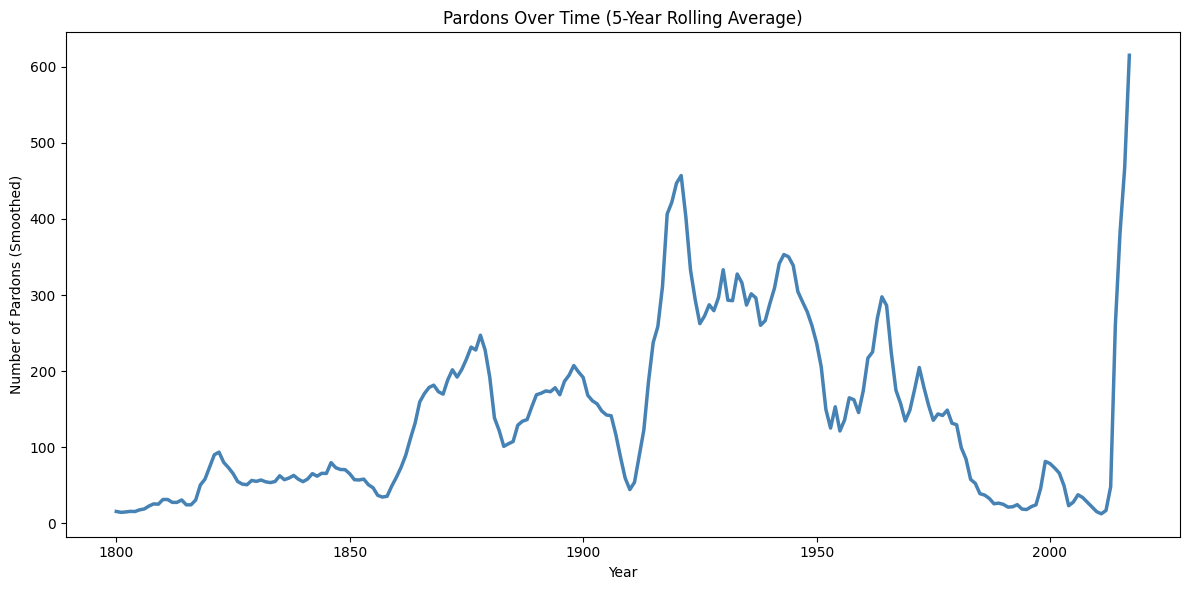

In [31]:
#(KA-code orginator) #(GS - code reviewer/reviser)
df = df.copy()

df["DATEACTION"] = pd.to_datetime(df["DATEACTION"], errors="coerce")
df["ACTION_YEAR"] = df["DATEACTION"].dt.year

df_plot = df[(df["ACTION_YEAR"] >= 1800) & (df["ACTION_YEAR"] <= 2020)].copy()
df_plot = df_plot.dropna(subset=["ACTION_YEAR"])
df_plot["ACTION_YEAR"] = df_plot["ACTION_YEAR"].astype(int) 

year_counts = (
    df_plot.groupby("ACTION_YEAR")
           .size()
           .reset_index(name="pardon_count")
           .sort_values("ACTION_YEAR")
)

all_years = pd.DataFrame({
    "ACTION_YEAR": range(year_counts.ACTION_YEAR.min(),
                         year_counts.ACTION_YEAR.max() + 1)
})

year_counts = all_years.merge(year_counts, on="ACTION_YEAR", how="left")

year_counts["pardon_count"] = year_counts["pardon_count"].fillna(0)

year_counts["pardon_smooth"] = (
    year_counts["pardon_count"]
               .rolling(window=5, center=True, min_periods=1)
               .mean()
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=year_counts,
    x="ACTION_YEAR",
    y="pardon_smooth",
    color="steelblue",
    linewidth=2.5
)

plt.title("Pardons Over Time (5-Year Rolling Average)")
plt.xlabel("Year")
plt.ylabel("Number of Pardons (Smoothed)")
plt.tight_layout()
plt.show()


## We then wanted to subject based on state but due to data input changes over the years, it was difficult to truly visualize this in the best way so instead we focused on regional differences by mapping each state to its specific region

/var/folders/2g/jqjm37dn3q74zcdhwhq_1k3w0000gn/T/ipykernel_29941/3217112770.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




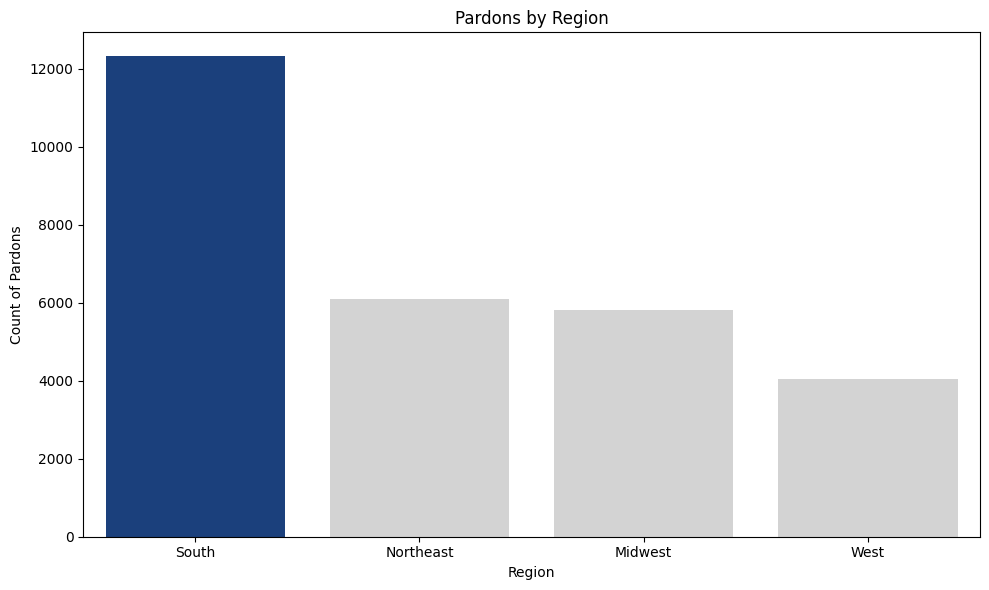

In [32]:
#(KA-code orginator) #(GS - code reviewer/reviser)
state_to_region = {
    # Northeast
    "CT": "Northeast", "ME": "Northeast", "MA": "Northeast", "NH": "Northeast",
    "RI": "Northeast", "VT": "Northeast", "NJ": "Northeast", "NY": "Northeast",
    "PA": "Northeast",

    # Midwest
    "IL": "Midwest", "IN": "Midwest", "MI": "Midwest", "OH": "Midwest", "WI": "Midwest",
    "IA": "Midwest", "KS": "Midwest", "MN": "Midwest", "MO": "Midwest",
    "NE": "Midwest", "ND": "Midwest", "SD": "Midwest",

    # South
    "DE": "South", "FL": "South", "GA": "South", "MD": "South", "NC": "South",
    "SC": "South", "VA": "South", "DC": "South", "WV": "South",
    "AL": "South", "KY": "South", "MS": "South", "TN": "South",
    "AR": "South", "LA": "South", "OK": "South", "TX": "South",

    # West
    "AZ": "West", "CO": "West", "ID": "West", "MT": "West", "NV": "West",
    "NM": "West", "UT": "West", "WY": "West",
    "AK": "West", "CA": "West", "HI": "West", "OR": "West", "WA": "West",
}

# Clean state abbreviations
df["STATE"] = df["STATE"].astype(str).str.strip().str.upper()

# Map states to regions
df["REGION"] = df["STATE"].map(state_to_region)

# Filter out rows where region is still missing
df_region = df[df["REGION"].notna()].copy()


plt.figure(figsize=(10,6))

region_order = df_region["REGION"].value_counts().index #(GS - code reviewer/reviser)

colors = ["#0b3c8c"] + ["#d3d3d3"] * (len(region_order) - 1)

sns.countplot(
    data=df_region,
    x="REGION",
    order=region_order,
    palette=colors
)

plt.title("Pardons by Region")
plt.xlabel("Region")
plt.ylabel("Count of Pardons")
plt.tight_layout()
plt.show()


## We also wanted to explore the number of pardons per president and how each president compares to one another. Outside factors were explored through research like population, party, and other occurences. 

/var/folders/2g/jqjm37dn3q74zcdhwhq_1k3w0000gn/T/ipykernel_29941/564560037.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




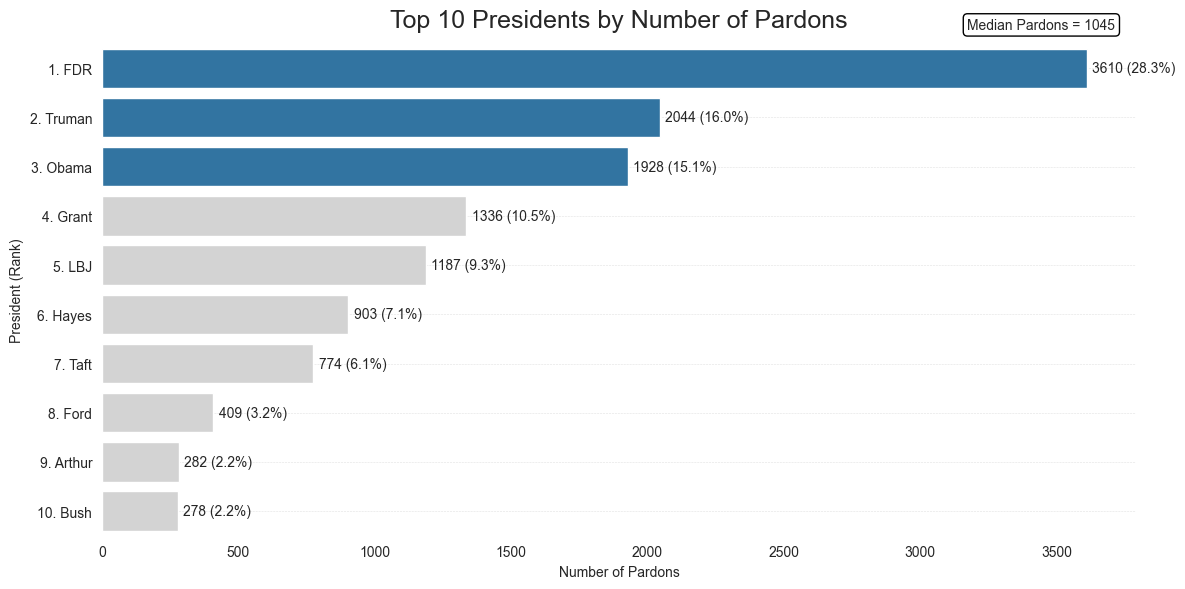

In [33]:
#(KA-code orginator) #(GS - code reviewer/reviser)
#List of valid presidents 
valid_presidents = [
    "Washington", "Adams", "Jefferson", "Madison", "Monroe", "J.Q. Adams",
    "Jackson", "Van Buren", "Harrison", "Tyler", "Polk", "Taylor", "Fillmore",
    "Pierce", "Buchanan", "Lincoln", "Johnson", "Grant", "Hayes", "Garfield",
    "Arthur", "Cleveland", "B. Harrison", "McKinley", "T. Roosevelt",
    "Taft", "Wilson", "Harding", "Coolidge", "Hoover", "FDR", "Truman",
    "Eisenhower", "JFK", "LBJ", "Nixon", "Ford", "Carter", "Reagan",
    "Bush", "Clinton", "G.W. Bush", "Obama", "Trump", "Biden"
]

# Clean president names 
df["PRES_CLEAN"] = df["PRES"].astype(str).str.strip()
df_clean = df[df["PRES_CLEAN"].isin(valid_presidents)].copy()
# Count pardons by president and sort
pres_counts = (
    df_clean.groupby("PRES_CLEAN")
            .size()
            .reset_index(name="pardon_count")
            .sort_values("pardon_count", ascending=False)
)

# Take Top 10 and build rank labels
pres_top10 = pres_counts.head(10).copy()
total_top10 = pres_top10["pardon_count"].sum()
median_pardons = pres_top10["pardon_count"].median()
ranks = pres_top10.reset_index(drop=True).index + 1 #(GS - code reviewer/reviser)
pres_top10["rank_label"] = ranks.astype(str) + ". " + pres_top10["PRES_CLEAN"]

highlight_color = "#1f77b4"   

top3_names = pres_top10.head(3)["PRES_CLEAN"].tolist()
colors = [
    highlight_color if name in top3_names else "lightgrey"
    for name in pres_top10["PRES_CLEAN"]
]

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("white")

ax = sns.barplot(
    data=pres_top10,
    y="rank_label",
    x="pardon_count",
    palette=colors
)

# Title and axis labels
plt.title("Top 10 Presidents by Number of Pardons", fontsize=18, pad=12)
plt.xlabel("Number of Pardons")
plt.ylabel("President (Rank)")
ax.grid(axis="y", linestyle="--", linewidth=0.4, alpha=0.6)
ax.grid(axis="x", linestyle="", linewidth=0)  # turn off vertical grid

ax.text(
    0.98, 1.03,
    f"Median Pardons = {int(median_pardons)}",
    transform=ax.transAxes,
    ha="right",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)


# labels #(GS - code reviewer/reviser)
for bar, (_, row) in zip(ax.patches, pres_top10.iterrows()):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    pct = 100 * width / total_top10
    ax.text(
        width + 20,
        y,
        f"{int(width)} ({pct:.1f}%)",
        va="center",
        fontsize=10
    )

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


## Incarceration Rates and Crime Type (Eric K)

Analyzing the different types of crimes and how they have changed over time. Each crime is individual to the pardon that was put into the dataset so a 1-1 mapping using Gemini was done to achieve this. This was a long process that is open to hallucinations and putting crimes into wrong categories

In [ ]:
# (EK - code originator)
#Display_Max_Rows(missing)
c = df_clean.groupby('OFFENSE').count()['CASEID']

Display_Max_Rows(c.sort_values())

OFFENSE
writ of execution ($2,080.21)                            1
writ of capias ad satisfaciendum                         1
writ for debt                                            1
wounding w/gunshot                                       1
wounding a freedman                                      1
world war veterans act                                   1
working unregistered still                               1
working in unsigned distillery                           1
working in unregistered distillery                       1
willfull.misapp.,embezz.natl.bank funds                  1
wire fraud, comood.exch                                  1
wire fraud,mail fraud,trade screts,int.trans.stole       1
wire,mail fraud                                          1
with.beer fr/keg w/out destr.stamp                       1
10 U.S.C. 336; 15 U.S.C. 77(q)(a)(1)                     1
11 U.S.C. 52(b)1                                         1
working in unlicen.distill,retail.distill.spirit

Sorting each offense type in the original, cleaned dataset

In [ ]:
# (EK - code originator)
# (GS - code reviser)
# (KA - code reviewer)
offenses = df_clean.groupby('OFFENSE').count()['CASEID']
Display_Max_Rows(c.sort_values())

offensesample = offenses.sample(50)

Display_Max_Rows(offensesample)

OFFENSE
beating and wounding a seaman                          1
false swearing nat. proceeding                         2
ownership dispute                                      1
making,sell.hair dye tax not pd.                       1
embezz letters w/art. of value                         1
26 U.S.C. 692                                          1
bigam/polyg.prior to Act Cong                          1
debt due US                                           26
concealing opium after importation                     1
embezzlement by postal emp                             3
ill.trans.dyno,nitroglycerin                           1
embezz.funds Nat. bank                                 1
consp. use mails to defraud                           18
consp. smuggle opium in US                             2
trans.stol.motor.veh                                   1
departing without clearance                            1
vio.20th,62nd articles of war                          1
filing a false income-t

There's way too many unique offenses here, so I will need AI to categorize them for me.

In [ ]:
# (EK - code originator)
#the prompt (EK)
slop = f"I have an issue where each of the offenses listed in my offensesample dataset is too uniquely labeled for analysis. I would like you to take each of the offenses in the dataset and manually assign them to one of the following categories: Alcohol, Non-Alcohol Drugs, Slavery, Fraud, Violent, Property, Sexual, Tax The final output should be a python dictionary with the original offenses as the keys and their assigned categorizations as the values. Here is the full list, with a few examples to get you started: \n`beating and wounding a seaman`:'violent' \n`false swearing nat. proceeding`:'fraud' `ownership dispute`:'property' \n`filing a false income-tax return`:'tax'"

def BuildPrompt(rows):
  proompt = ''
  rows2 = rows.index.tolist()
  for i in rows2:
     proompt += (f"\n'"+i+"':")
  return slop + proompt

a = BuildPrompt(offensesample[3:])

print(a)

I have an issue where each of the offenses listed in my offensesample dataset is too uniquely labeled for analysis. I would like you to take each of the offenses in the dataset and manually assign them to one of the following categories: Alcohol, Non-Alcohol Drugs, Slavery, Fraud, Violent, Property, Sexual, Tax The final output should be a python dictionary with the original offenses as the keys and their assigned categorizations as the values. Here is the full list, with a few examples to get you started: 
`beating and wounding a seaman`:'violent' 
`false swearing nat. proceeding`:'fraud' `ownership dispute`:'property' 
`filing a false income-tax return`:'tax'
'making,sell.hair dye tax not pd.':
'embezz letters w/art. of value':
'26 U.S.C. 692':
'bigam/polyg.prior to Act Cong':
'debt due US':
'concealing opium after importation':
'embezzlement by postal emp':
'ill.trans.dyno,nitroglycerin':
'embezz.funds Nat. bank':
'consp. use mails to defraud':
'consp. smuggle opium in US':
'trans.s

To keep personal API keys safe, this key was removed to not push publicly. The output from that AI call is shown below.

In [ ]:
# (EK - code originator)
# (GS - code reviser)
# (KA - code reviewer)
# (EK)
from google import genai

api = open('geminikey.txt','r').read() 
client = genai.Client(api_key = api)

def PhoneGemini(str):
    response = client.models.generate_content(
      model="gemini-2.5-flash",
      contents=str,
    )
    return response

print(PhoneGemini(a).text)

Here are the offenses from your dataset, manually assigned to the specified categories:

```python
{
    'beating and wounding a seaman': 'Violent',
    'false swearing nat. proceeding': 'Fraud',
    'ownership dispute': 'Property',
    'filing a false income-tax return': 'Tax',
    'making,sell.hair dye tax not pd.': 'Tax',
    'embezz letters w/art. of value': 'Fraud',
    '26 U.S.C. 692': 'Tax',
    'bigam/polyg.prior to Act Cong': 'Sexual',
    'debt due US': 'Tax',
    'concealing opium after importation': 'Non-Alcohol Drugs',
    'embezzlement by postal emp': 'Fraud',
    'ill.trans.dyno,nitroglycerin': 'Violent',
    'embezz.funds Nat. bank': 'Fraud',
    'consp. use mails to defraud': 'Fraud',
    'consp. smuggle opium in US': 'Non-Alcohol Drugs',
    'trans.stol.motor.veh': 'Property',
    'departing without clearance': 'Fraud',
    'vio.20th,62nd articles of war': 'Violent',  # Article 20 covered Mutiny, Article 62 Desertion. Mutiny can be violent.
    'sell.liquor to Indians

Initial list of crime types for mapping

In [ ]:
# (EK - code originator)
#My choice of categories wasn't perfect but this looks pretty good (EK)
offense_categorizations = {
    'beating and wounding a seaman': 'Violent',
    'false swearing nat. proceeding': 'Fraud',
    'ownership dispute': 'Property',
    'filing a false income-tax return': 'Tax',
    'making,sell.hair dye tax not pd.': 'Tax',
    'embezz letters w/art. of value': 'Property',
    '26 U.S.C. 692': 'Tax',
    'bigam/polyg.prior to Act Cong': 'Fraud',
    'debt due US': 'Fraud',
    'concealing opium after importation': 'Non-Alcohol Drugs',
    'embezzlement by postal emp': 'Property',
    'ill.trans.dyno,nitroglycerin': 'Violent',
    'embezz.funds Nat. bank': 'Fraud',
    'consp. use mails to defraud': 'Fraud',
    'consp. smuggle opium in US': 'Non-Alcohol Drugs',
    'trans.stol.motor.veh': 'Property',
    'departing without clearance': 'Fraud',
    'vio.20th,62nd articles of war': 'Violent',
    'sell.liquor to Indians': 'Alcohol',
    'imperson.US officer': 'Fraud',
    'vio.law rel.spirit.liq.': 'Alcohol',
    'f.altering, passing nat.bank note': 'Fraud',
    'fraud.remov.labels fr/oleo.pack': 'Fraud',
    'ill.put man in mil.serv. of US': 'Violent',
    'make f.entries in nat.bank as cashier': 'Fraud',
    'stealing small amt.money f/PO': 'Property',
    'use of a telephone to facilitate commission of dru': 'Non-Alcohol Drugs',
    'embezz.parcel-post packages': 'Property',
    'poss. counterf. coin molds': 'Fraud',
    'main.nuisance vio.proh.act': 'Alcohol',
    'poss.,sell. liq.,maint.common nuisance': 'Alcohol',
    's472,title18,USC': 'Fraud',
    'detain,open.letters,took 3 $1 cert f/one': 'Property',
    'sect 4744(a)(2) title 26 usc': 'Tax',
    'forgery,vio.Sec.5485 Rev.Stat.US': 'Fraud',
    'impersonating US officer (2)': 'Fraud',
    'detain,opening letter containing money': 'Property',
    'cond.prej.order of mil.': 'Violent',
    'embezzlement of postal funds & falsification of po': 'Fraud',
    'vio.postal laws as PO worker': 'Fraud',
    'defalcation in PO': 'Fraud',
    'manslaughter,desertion': 'Violent',
    'consp,violation sel.serv.act': 'Fraud',
    'vio.act.rel.excesss.passengers': 'Fraud',
    'breaking into and stealing fr/PO,conceal.post.stam': 'Property',
    'murder, committed on govt. reservation': 'Violent',
    'vio.act.rel.ventillation appar.': 'Fraud',
    'consp,deal.stolen autos trans.int.comm.': 'Property',
    'intro. liq. into indian country': 'Alcohol',
    'conps. violate criminal code': 'Fraud'
}


I have an issue where each of the offenses listed in my offensesample dataset is too uniquely labeled for analysis. I would like you to take each of the offenses in the dataset and manually assign them to one of the following categories: Alcohol, Non-Alcohol Drugs, Slavery, Fraud, Violent, Property, Sexual, Tax The final output should be a python dictionary with the original offenses as the keys and their assigned categorizations as the values. Here is the full list, with a few examples to get you started: 
`beating and wounding a seaman`:'violent' 
`false swearing nat. proceeding`:'fraud' `ownership dispute`:'property' 
`filing a false income-tax return`:'tax'
'making,sell.hair dye tax not pd.':
'embezz letters w/art. of value':
'26 U.S.C. 692':
'bigam/polyg.prior to Act Cong':
'debt due US':
'concealing opium after importation':
'embezzlement by postal emp':
'ill.trans.dyno,nitroglycerin':
'embezz.funds Nat. bank':
'consp. use mails to defraud':
'consp. smuggle opium in US':
'trans.s

The new plan will be to feed gemini the whole dataset in batches and save it all into a big text file. Once I have that, I can convert it into a proper dictionary that will let me encode the original dataset.

The 'offenses' dataset is 10735 rows long...

In [ ]:
# (EK - code originator)
# (GS - code reviser)
# (KA - code reviewer)
import os
!mkdir ./gemini_outputs

def save_text(text, path):
    f = open(path, 'w', encoding='utf-8')
    f.write(text)
    f.close()

for slice in range(3,10750,100):
  temp = PhoneGemini(BuildPrompt(offenses[slice:slice+100]))
  save_text(temp.text, 'gemini_outputs/gemini_{}'.format(slice))

#b = PhoneGemini(BuildPrompt(offenses[3:100]))
#print(b.text)

mkdir: cannot create directory ‘./gemini_outputs’: File exists


In [ ]:
# (EK - code originator)
#just in case
import shutil
shutil.make_archive('gemini', 'zip', 'gemini_outputs') #last one is the directory to grab

'/content/gemini.zip'

In [ ]:
# (EK - code originator)
# (GS - code reviser)
# (KA - code reviewer)
import re
import ast

#I had to delete about 10 files because they wouldn't play nice with this code. (EK)
def GeminiToDict(st):
  st2 = re.findall(r"\{[^}]*\}", st)
  st2 = re.sub(r"#.*?\n",'\n',st2[0])
  st2 = re.sub("[\n]",'',st2)
  return ast.literal_eval(st2)

thebible = {}
for gemini_path in os.listdir('./gemini_outputs'):
  filename = os.fsdecode(gemini_path)
  print(filename)
  if 'gemini' in filename:
    tempstr = open('./gemini_outputs/'+filename,'r')
    thebible = thebible | GeminiToDict(tempstr.read())

thebible


gemini_5203
gemini_8603
gemini_5603
gemini_6103
gemini_7603
gemini_1203
gemini_4903
gemini_6903
gemini_6503
gemini_9903
gemini_7703
gemini_9303
gemini_9203
gemini_3303
gemini_803
gemini_4203
gemini_10703
gemini_403
gemini_7203
gemini_1603
gemini_4403
gemini_8503
gemini_3003
gemini_5403
gemini_2103
gemini_9403
gemini_8303
gemini_6703
gemini_1803
gemini_8103
.ipynb_checkpoints
gemini_10603
gemini_8203
gemini_2403
gemini_10303
gemini_7403
gemini_5303
gemini_3403
gemini_2303
gemini_3603
gemini_8903
gemini_5803
gemini_3703
gemini_7803
gemini_1903
gemini_6303
gemini_3903
gemini_1703
gemini_2603
gemini_9103
gemini_7003
gemini_10403
gemini_7103
gemini_303
gemini_5903
gemini_9003
gemini_2803
gemini_3
gemini_7903
gemini_4603
gemini_4303
gemini_2003
gemini_1103
gemini_5103
gemini_7303
gemini_10003
gemini_6003
gemini_2203
gemini_6203
gemini_2703
gemini_2903
gemini_8403
gemini_10203
gemini_8803
gemini_203
gemini_10103
gemini_6803
gemini_703
gemini_4103
gemini_603
gemini_3103
gemini_903
gemini_1403


{'beating and wounding a seaman': 'Violent',
 'false swearing nat. proceeding': 'Fraud',
 'ownership dispute': 'Property',
 'filing a false income-tax return': 'Tax',
 'ill.registr.as voter,ill.voting': 'fraud',
 'ill.registration as voter': 'fraud',
 'ill.rem.dist.liq.fr/bond.warehouse': 'alcohol',
 'ill.remov,conceal.spirits': 'alcohol',
 'ill.remov,poss.unstamped tobacco': 'tax',
 'ill.remov.dist.spirits': 'alcohol',
 'ill.remov.distill.spir.': 'alcohol',
 'ill.removal distill spirits': 'alcohol',
 'ill.remove distill.spirits': 'alcohol',
 'ill.removed distill.liq': 'alcohol',
 'ill.retail.distill.liquor': 'alcohol',
 'ill.retail.spir.liq.': 'alcohol',
 'ill.return to US': 'fraud',
 'ill.sale cocaine': 'non-alcohol drugs',
 'ill.sale cocaine,morphine': 'non-alcohol drugs',
 'ill.sale intox.liq to indians': 'alcohol',
 'ill.sale morphine sulphate': 'non-alcohol drugs',
 'ill.sale narc,concp.vio.Harr.Act': 'non-alcohol drugs',
 'ill.sale,aid.sale narcotics': 'non-alcohol drugs',
 'ill

In [ ]:
#Display_Max_Rows(missing)
# (EK - code originator)
# (GS - code reviser)
# (KA - code reviewer)
df_offenses = df_clean.copy()
df_offenses = df_offenses.replace(r'^\s*$', np.nan, regex=True)
df_offenses['OFFENSE'] = df_offenses['OFFENSE'].replace(thebible)
df_offenses['OFFENSE'] = df_offenses['OFFENSE'].str.lower()
df_offenses = df_offenses[df_offenses['OFFENSE'].isin(['fraud','property','alcohol','violent','tax','non-alcohol drugs','sexual','slavery'])]

In [ ]:
# (EK - code originator)
df_offenses['OFFENSE'] = df_offenses['OFFENSE'].str.lower()
Display_Max_Rows(df_offenses.groupby('OFFENSE').count()['CASEID'].sort_values())

OFFENSE
slavery               262
sexual                556
non-alcohol drugs    1090
tax                  1238
violent              3187
alcohol              3601
property             3897
fraud                8940
Name: CASEID, dtype: int64


In [ ]:
# (EK)
import seaborn as sns

df_offenses['YEARACTION'] = df_offenses['DATEACTION'].dt.year
off_tochart = df_offenses.groupby(['YEARACTION','OFFENSE']).count()
off_tochart = off_tochart.reset_index(level = 0)

off_tochart['YEARROLLING'] = off_tochart['YEARACTION'].rolling(window=5, center=True, min_periods=1).mean()

off_tochart

,YEARACTION,CASEID,FILEID,PRES,PRESIDENT,TERMYR,PG,PG_A,PAGE,SSVOL,...,SUP,LAWYER,AGE,BUREACRACY,TOTALWAIT,PRISON,V22,V23,TOWHITEHOUSE,YEARROLLING
OFFENSE,,,,,,,,,,,,,,,,,,,,,
fraud,1791.0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1792.666667
property,1793.0,2,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1793.000000
fraud,1794.0,2,2,1,0,0,1,0,0,1,...,0,0,0,0,0,2,0,0,0,1793.400000
property,1794.0,4,4,3,0,0,3,0,0,3,...,0,0,0,0,0,4,0,0,0,1794.400000
violent,1795.0,1,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1795.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fraud,2016.0,28,28,28,0,0,0,0,0,0,...,28,0,5,0,0,14,0,0,0,2015.600000
non-alcohol drugs,2016.0,35,35,35,0,0,0,0,0,0,...,32,0,0,0,0,30,0,0,0,2015.800000
property,2016.0,9,9,9,0,0,0,0,0,0,...,8,0,0,0,0,4,0,0,0,2016.200000


Text(0.5, 1.0, 'Types of crimes pardoned since 1970')

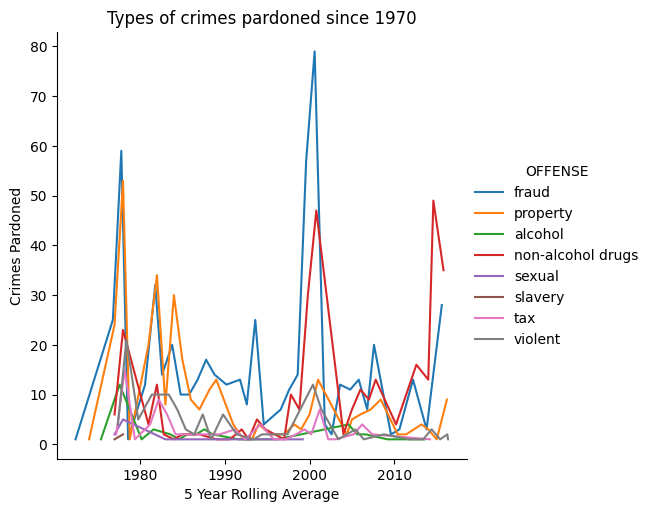

In [ ]:
# (EK - code originator)
# (GS - code reviser)
# (KA - code reviewer)
sns.relplot(
    data=off_tochart[off_tochart['YEARACTION']>1970], x="YEARROLLING", y="CASEID",
    hue="OFFENSE", kind="line",
)
plt.ylabel('Crimes Pardoned')
plt.xlabel('5 Year Rolling Average')
plt.title('Types of crimes pardoned since 1970')

In [ ]:
# (EK - code originator)
# (KA - code reviewer)
torment = off_tochart.reset_index(level = 0)
torment = torment.pivot(index='YEARACTION', columns='OFFENSE', values = 'CASEID')
torment_pct = torment.div(torment.sum(axis=1), axis=0)
torment_pct

OFFENSE,alcohol,fraud,non-alcohol drugs,property,sexual,slavery,tax,violent
YEARACTION,,,,,,,,
1791.0,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
1793.0,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
1794.0,NaN,0.333333,NaN,0.666667,NaN,NaN,NaN,NaN
1795.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1796.0,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,0.333333
...,...,...,...,...,...,...,...,...
2013.0,NaN,0.382353,0.470588,0.117647,NaN,NaN,NaN,0.029412
2014.0,0.041667,0.125000,0.541667,0.125000,NaN,NaN,0.041667,0.125000
2015.0,NaN,NaN,0.960784,0.019608,NaN,NaN,NaN,0.019608


Text(0, 0.5, '%')

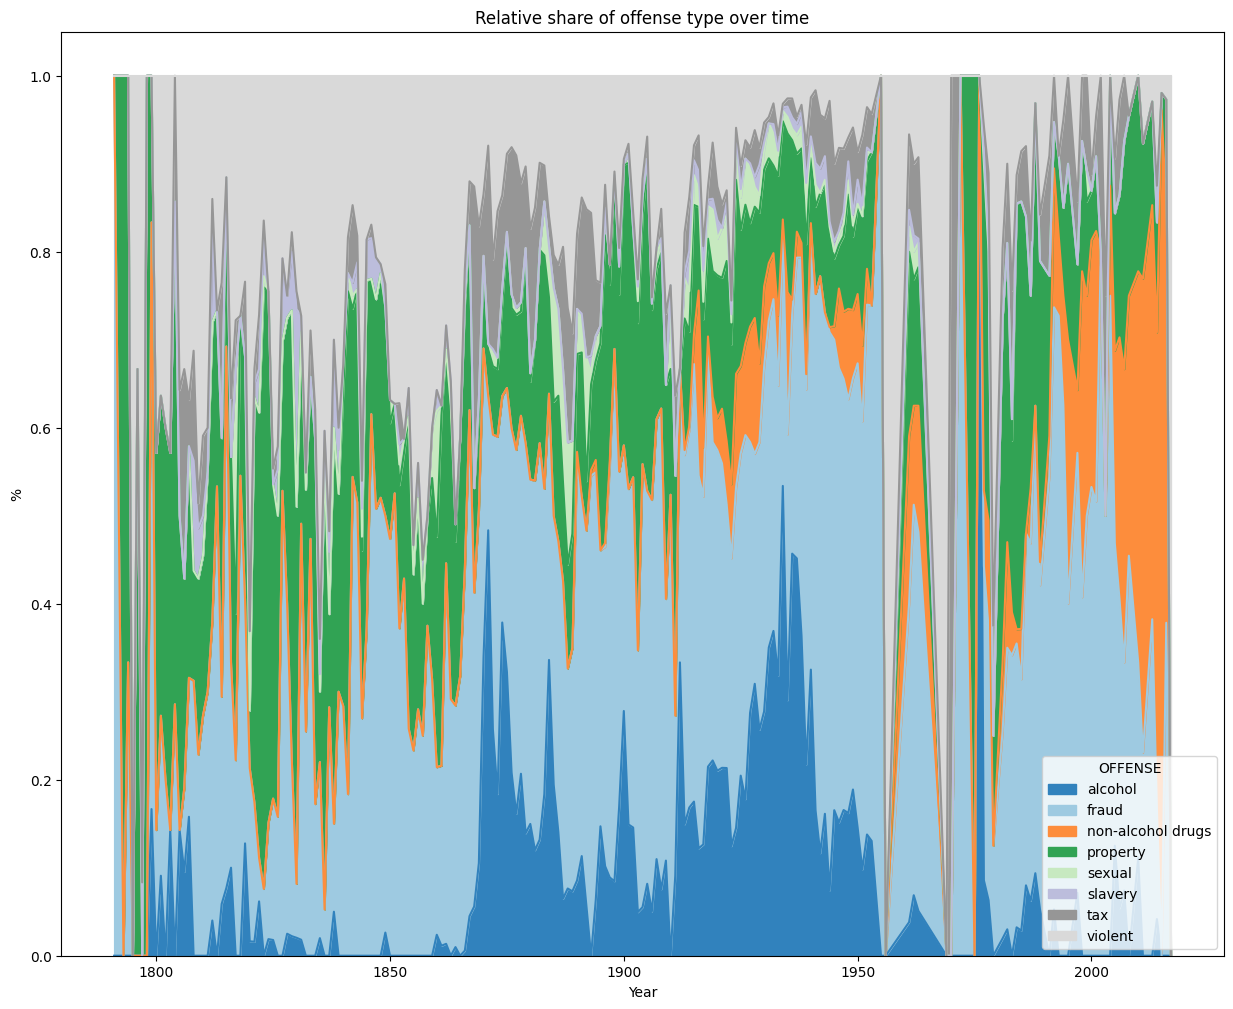

In [ ]:
# (EK - code originator)
# (GS - code reviser)
# (KA - code reviewer)
#Perhaps an area plot describing the percentage share of each crime type would be better
import matplotlib
newcolors = matplotlib.colors.ListedColormap(['#db2a30','#2465ff','#1a1a1a','#1a1a1a','#1a1a1a','#1a1a1a','#1a1a1a','#1a1a1a']) #ok i do not have time to invent a better color scheme
torment_pct.plot(kind = "area", figsize = (15,12), colormap = 'tab20c', title = 'Relative share of offense type over time') #not quite
plt.xlabel('Year')
plt.ylabel('%')

Text(0, 0.5, '%')

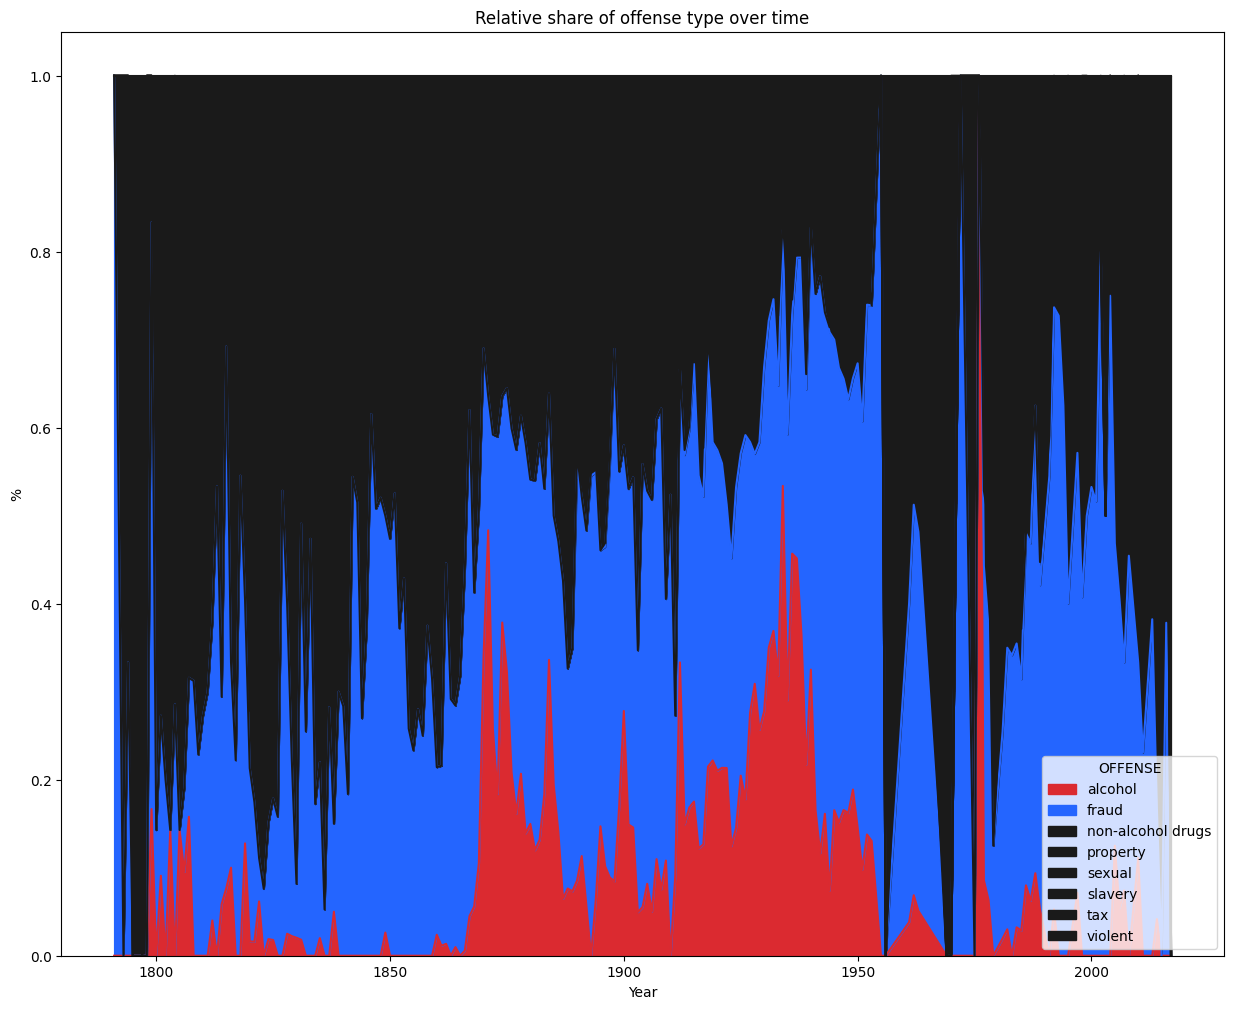

In [ ]:
# (EK - code originator)
#alt chart
torment_pct.plot(kind = "area", figsize = (15,12), colormap = newcolors, title = 'Relative share of offense type over time') #not quite
plt.xlabel('Year')
plt.ylabel('%')

In [ ]:
# (EK - code originator)
# (GS - code reviser)
# (KA - code reviewer)
#Lastly I will make a simple table showing the total count of each type. (EK)
df_offenses.groupby('OFFENSE').count().rename(columns = {'CASEID':'Total'})['Total']

,Total
OFFENSE,
alcohol,3601
fraud,8940
non-alcohol drugs,1090
property,3897
sexual,556
slavery,262
tax,1238
violent,3187
